# Drill: fixing assumptions
Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality. See what you can do to fix it.

In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


The model where the outcome Sales is predicted by the features TV, Radio, and Newspaper explains 89.7% of the variance in Sales.  Note that we don't know from these results how much of that variance is explained by each of the three features.  Looking at the coefficients, there appears to be a base rate of Sales that happen even with no ads in any medium (intercept: 2.939) and sales have the highest per-unit increase when ads are on the radio (0.189).  

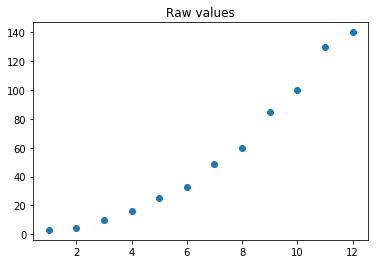

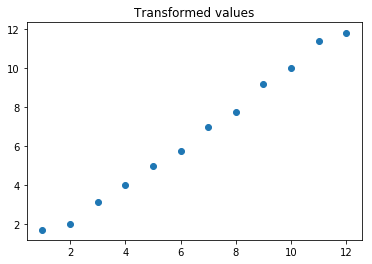

In [3]:
# Fixing a quadratic relationship to make it linear
# Sample data.
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

# Plot the data as-is. Looks a mite quadratic.
plt.scatter(outcome, feature)
plt.title('Raw values')
plt.show()

# Create a feature using a non-linear transformation.
sqrt_feature = [math.sqrt(x) for x in  feature]


# Well now isn't that nice.
plt.scatter(outcome, sqrt_feature)
plt.title('Transformed values')
plt.show()

### Multivariate normality

The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed.  Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

> ***Outliers or skewness in error can often be traced back to outliers or skewness in data.***  

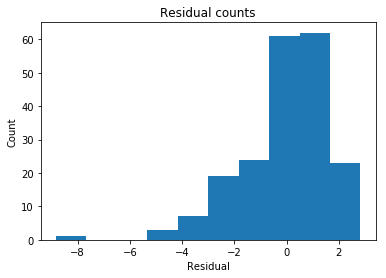

In [13]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

C:\Users\AES\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


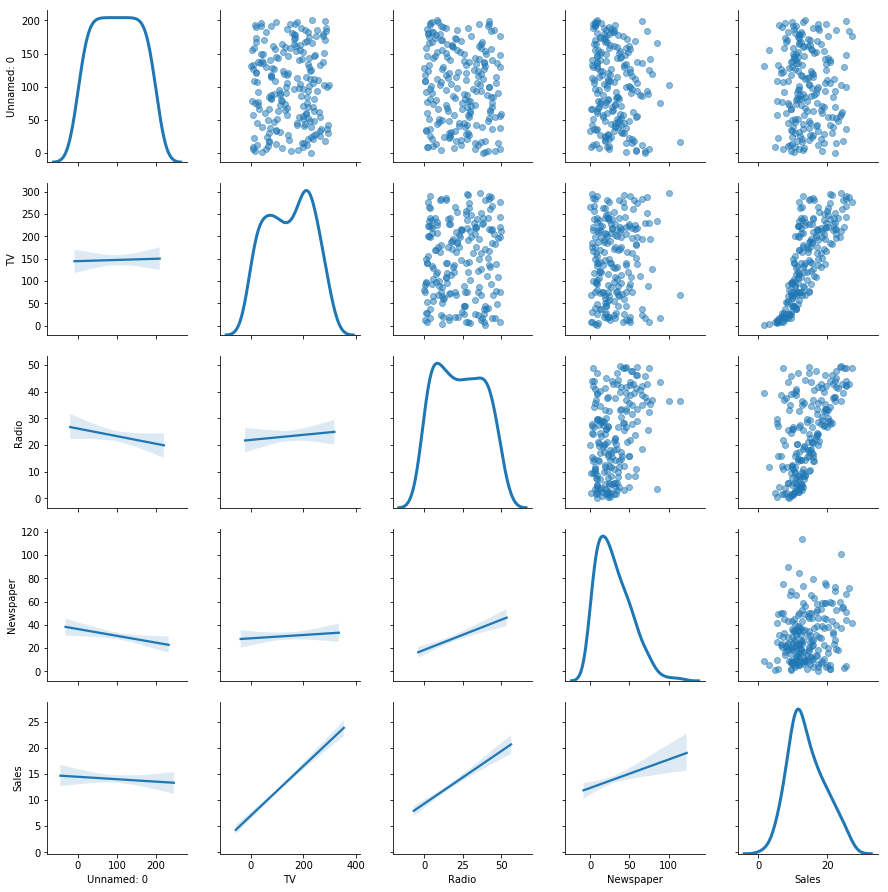

In [5]:
# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(data.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Newspaper advertising is right skewed (towards lower values), and doesn't seem to be linear with sales.  

In [6]:
tv_feat = data['TV']
radio_feat = data['Radio']
newsp_feat = data['Newspaper']

# Create a feature using a non-linear transformation.
data['sqrt_tv'] = [math.sqrt(x) for x in  tv_feat]
data['sqrt_rdo'] = [math.sqrt(x) for x in  radio_feat]
data['sqrt_nwp'] = [math.sqrt(x) for x in  newsp_feat]

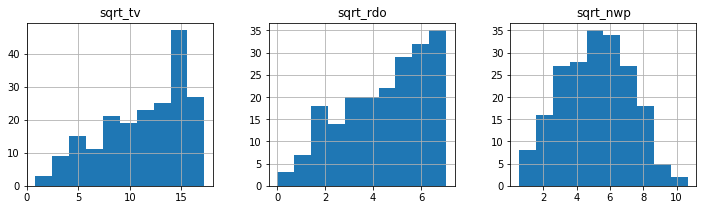

In [7]:
# Define the histogram plotting function
def plot_hists(dframe, fts):
    fig, axes = plt.subplots(1, len(fts), figsize=(12,3))
    for f in fts:
        idx = fts.index(f)
        dframe.hist(f, ax=axes[idx])

# Plot histograms for each variable
variables = ['sqrt_tv', 'sqrt_rdo', 'sqrt_nwp']
plot_hists(data, variables)

Now the newpaper feature is normalized, but TV and Radio are both skewing to the right

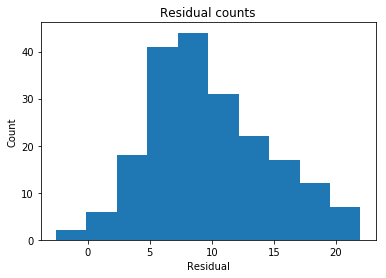

In [11]:
#Plot the sales data again with the square rooted features
X2 = data[['sqrt_tv','sqrt_rdo','sqrt_nwp']]

# Extract predicted values.
predicted2 = regr.predict(X2).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual2 = actual - predicted2

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

Even though the tv and radio data started to skew after the square roots were taken, the data is now normalized.


### Homoscedasticity

The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or **homoscedastic**.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance.  This leads to overconfidence in the accuracy of your model's predictions.

> ***Some fixes to heteroscedasticity include transforming the dependent variable and adding features that target the poorly-estimated areas.*** 

For example, if a model tracks data over time and model error variance jumps in the September to November period, a binary feature indicating season may be enough to resolve the problem.

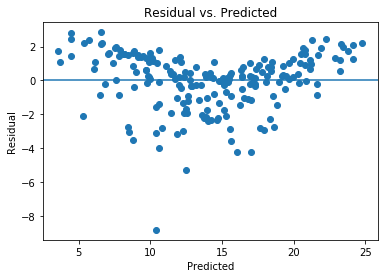

In [14]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

To address heteroscedasticity, I need to transform the dependent variable (sales).

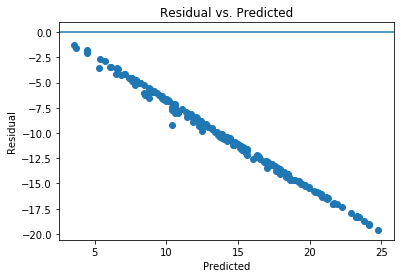

In [10]:
# take the square root of the sales data then re-plot
sales = data['Sales']
data['sqrt_sales'] = [math.sqrt(x) for x in  sales]
#X = data[['TV','Radio','Newspaper']]

predicted3 = regr.predict(X).ravel()
actual3 = data['sqrt_sales']

# Calculate the error, also called the residual.
residual3 = actual3 - predicted3

#plot
plt.scatter(predicted3, residual3)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

By simply taking the square root of the sales data (dependent variable), the error terms have been distributed homoscedastically.